# CSV reading and analysis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from collections import Counter
import ast

In [ ]:
# Load the dataset
data = pd.read_csv("API1.csv", sep=',')

In [3]:
# Sort by artist name and popularity in descending order for proper ranking
data = data.sort_values(by=['artist_name', 'popularity'], ascending=[True, False])

- Energy	A measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy.
- Tempo	The speed of a track, measured in beats per minute (BPM).
- Danceability	A score describing how suitable a track is for dancing based on tempo, rhythm stability, beat strength and overall regularity.
- Loudness	The overall loudness of a track in decibels (dB). Higher values indicate louder tracks overall.
- Liveness	The likelihood of a track being performed live. Higher values suggest more audience presence.
- Valence	The overall musical positiveness(emotion) of a track. High valence sounds happy; low valence sounds sad or angry.
- Speechiness	Measures the presence of spoken words.
- Instrumentalness	The likelihood a track contains no vocals. Values closer to 1.0 suggest solely instrumental tracks.
- Mode	Indicates the modality of the track.
- Key	The musical key, represented as an integer from 0 to 11, mapping to standard Pitch class notation.
- Duration_ms	The length of the track in milliseconds.
- Acousticness	A confidence measure of whether a track is acoustic(1) or not(0).

# Pre processing
### Genre simplification

In [4]:

# Flatten all genre tags
all_genres = data['genres'].explode()
all_genres = all_genres.dropna().str.lower()  # ensure uniform casing

# Count most common tags
top_30_genres = Counter(all_genres).most_common(30)
top_30_genres = [genre for genre, count in top_30_genres]
#print("Top 30 genres:", top_30_genres)

def map_to_main_genres(genre_list, top_genres):
    if not isinstance(genre_list, list):
        return []
    return list({genre.lower() for genre in genre_list if genre.lower() in top_genres})


# Step 1: Ensure genre column is list-type where possible
def ensure_list(val):
    if isinstance(val, list):
        return val
    if pd.isna(val):
        return []
    if isinstance(val, str):
        try:
            # attempt to parse stringified list
            parsed = ast.literal_eval(val)
            if isinstance(parsed, list):
                return parsed
        except:
            return [val]
    return []

data['genres'] = data['genres'].apply(ensure_list)

# Step 2: Simplify genres to keywords
main_genres = ['pop', 'rock', 'hip hop', 'edm', 'house', 'reggaeton']

def simplify_genre_keywords(genre_list, keywords):
    simplified = set()
    for genre in genre_list:
        genre_lower = genre.lower()
        for keyword in keywords:
            if keyword in genre_lower:
                simplified.add(keyword)
    return list(simplified)

# Step 3: Apply the simplification
data['main_genres'] = data['genres'].apply(lambda x: simplify_genre_keywords(x, main_genres))

# Preview
#print(data[['genres', 'main_genres']].head())



### Collaborator column

In [5]:
# Safely convert stringified lists to real lists
def parse_collaborators(value):
    if isinstance(value, str):
        try:
            return ast.literal_eval(value)
        except Exception:
            return []
    elif isinstance(value, list):
        return value
    return []

data['collaborators'] = data['collaborators'].apply(parse_collaborators)
#  Create binary column for whether track has collaborators
data['has_collaborator'] = data['collaborators'].apply(lambda x: len(x) > 0 if isinstance(x, list) else False)


# Informative data
### Counts and data

In [6]:
# Total number of rows
print("Total songs:", len(data))

# Unique artists
print("Unique artists:", data['artist_name'].nunique())

# Rows with no missing values
print("Complete entries:", data.dropna().shape[0])

# Songs per main genre
genre_counts = data.explode('main_genres')['main_genres'].value_counts()
print("\nSongs per main genre:")
print(genre_counts)

# Songs with collaborators
collab_count = data['has_collaborator'].sum()
print("\nSongs with collaborators:", collab_count)

# Songs without collaborators
no_collab_count = (~data['has_collaborator']).sum()
print("Songs without collaborators:", no_collab_count)

# Mean popularity overall and by main genre
print("\nOverall average popularity:", round(data['popularity'].mean(), 2))
avg_pop_by_genre = data.explode('main_genres').groupby('main_genres')['popularity'].mean().sort_values(ascending=False)
print("\nAverage popularity by main genre:")
print(avg_pop_by_genre)

# Track length stats (in minutes)
print("\nTrack length (min) — Mean:", round(data['duration_min'].mean(), 2),
      "| Median:", round(data['duration_min'].median(), 2))

# Tempo stats
print("Tempo (BPM) — Mean:", round(data['tempo'].mean(), 1),
      "| Median:", round(data['tempo'].median(), 1))

# Popularity distribution per collaboration status
print("\nAverage popularity — With collaborator:",
      round(data[data['has_collaborator']]['popularity'].mean(), 2))
print("Average popularity — Without collaborator:",
      round(data[~data['has_collaborator']]['popularity'].mean(), 2))

# Distribution of release days
data['release_dayofweek'] = pd.to_datetime(data['release_date'], errors='coerce').dt.day_name()
print("\nMost common release days:")
print(data['release_dayofweek'].value_counts())


Total songs: 941
Unique artists: 94
Complete entries: 714

Songs per main genre:
main_genres
pop          611
hip hop      170
reggaeton     80
rock          70
house         30
edm           20
Name: count, dtype: int64

Songs with collaborators: 378
Songs without collaborators: 563

Overall average popularity: 75.79

Average popularity by main genre:
main_genres
hip hop      77.352941
reggaeton    77.037500
house        76.566667
edm          76.300000
pop          74.885434
rock         73.042857
Name: popularity, dtype: float64

Track length (min) — Mean: 3.49 | Median: 3.41
Tempo (BPM) — Mean: 121.4 | Median: 120.0

Average popularity — With collaborator: 76.07
Average popularity — Without collaborator: 75.6

Most common release days:
release_dayofweek
Friday       579
Thursday     114
Tuesday       89
Monday        77
Wednesday     37
Saturday      20
Sunday        14
Name: count, dtype: int64


# Questions
### How do different spotify feature scores affect track popularity?

In [7]:
data.columns
data.to_csv("APIdatafixed.csv", index=False)

In [8]:
# Selecting the specified columns for correlation analysis
correlation_data = data[['danceability', 'popularity', 'artist_popularity', 'duration_min', 'tempo']]

# Calculating the correlation matrix
correlation_matrix = correlation_data.corr()

# Displaying the correlation matrix
correlation_matrix


,danceability,popularity,artist_popularity,duration_min,tempo
danceability,1.000000,-0.046063,-0.065064,-0.203973,-0.051500
popularity,-0.046063,1.000000,0.620196,-0.003978,0.077683
artist_popularity,-0.065064,0.620196,1.000000,0.159661,0.003080
duration_min,-0.203973,-0.003978,0.159661,1.000000,-0.061877
tempo,-0.051500,0.077683,0.003080,-0.061877,1.000000


### How does track length relate to track popularity with top artists?

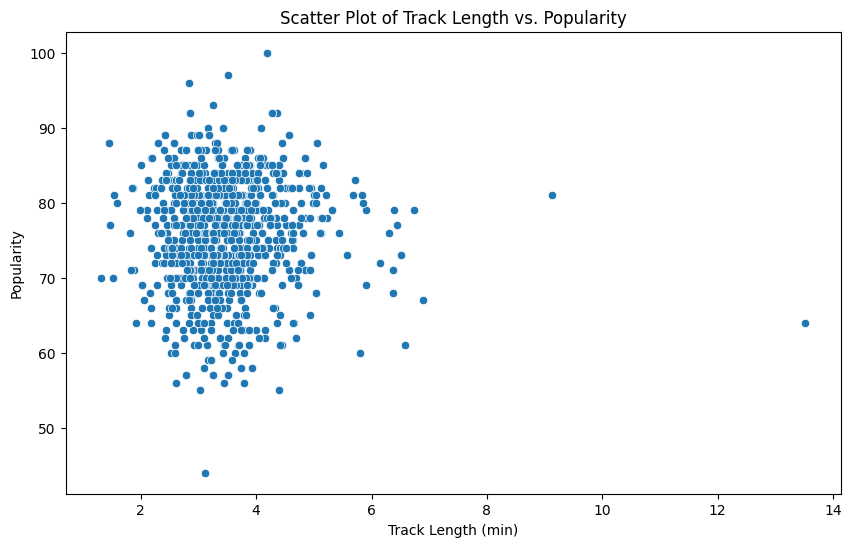

In [9]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['duration_min'], y=data['popularity'])
plt.title("Scatter Plot of Track Length vs. Popularity")
plt.xlabel("Track Length (min)")
plt.ylabel("Popularity")
plt.show()

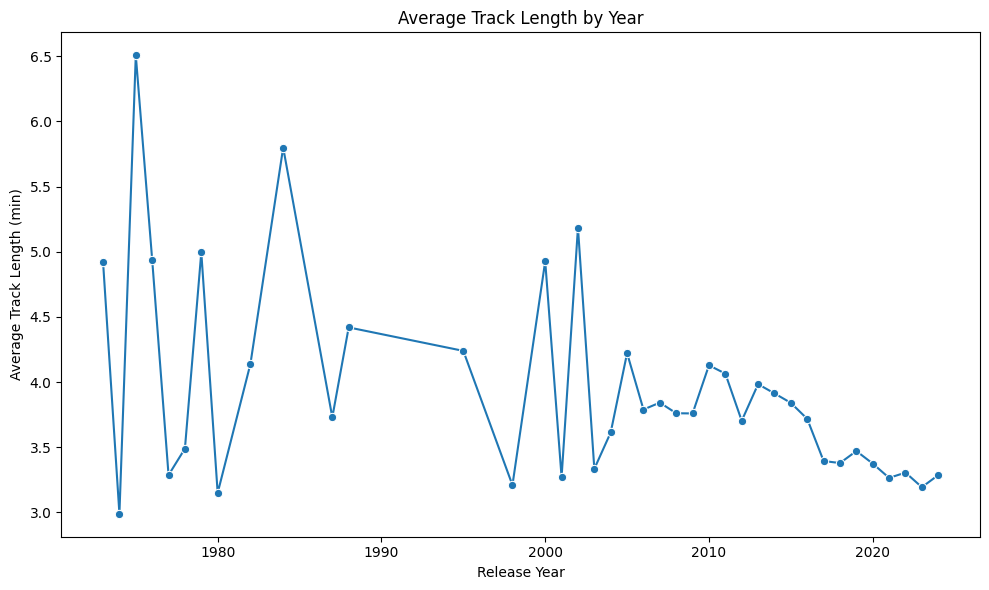

In [10]:
# Ensure release_year is extracted
data['release_year'] = (
    pd.to_datetime(data['release_date'], errors='coerce', format='%Y-%m-%d')
    .dt.year
)

# Group by year and compute average duration
yearly_avg_length = (
    data.groupby('release_year')['duration_min']
    .mean()
    .reset_index()
)

# Plot: Line plot of average duration by year
plt.figure(figsize=(10, 6))
sns.lineplot(data=yearly_avg_length, x='release_year', y='duration_min', marker='o')
plt.title("Average Track Length by Year")
plt.xlabel("Release Year")
plt.ylabel("Average Track Length (min)")
plt.tight_layout()
plt.show()


# Genre, collaborations and popularity

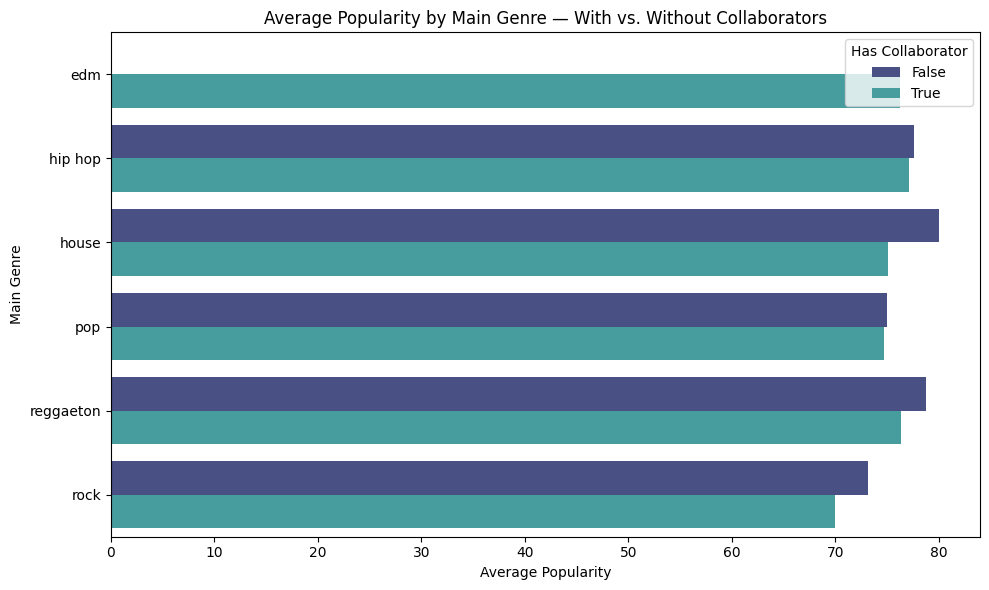

In [11]:
# Step 1: Explode the main_genres column
exploded = data.explode('main_genres')
exploded = exploded.dropna(subset=['main_genres'])

# Step 2: Group by simplified genre and collab status
main_genre_collab_stats = (
    exploded.groupby(['main_genres', 'has_collaborator'])
    .agg(avg_popularity=('popularity', 'mean'),
         count=('popularity', 'count'))
    .reset_index()
)

# Step 3: Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=main_genre_collab_stats,
    x='avg_popularity',
    y='main_genres',
    hue='has_collaborator',
    palette='mako'
)

plt.title("Average Popularity by Main Genre — With vs. Without Collaborators")
plt.xlabel("Average Popularity")
plt.ylabel("Main Genre")
plt.legend(title="Has Collaborator")
plt.tight_layout()
plt.show()

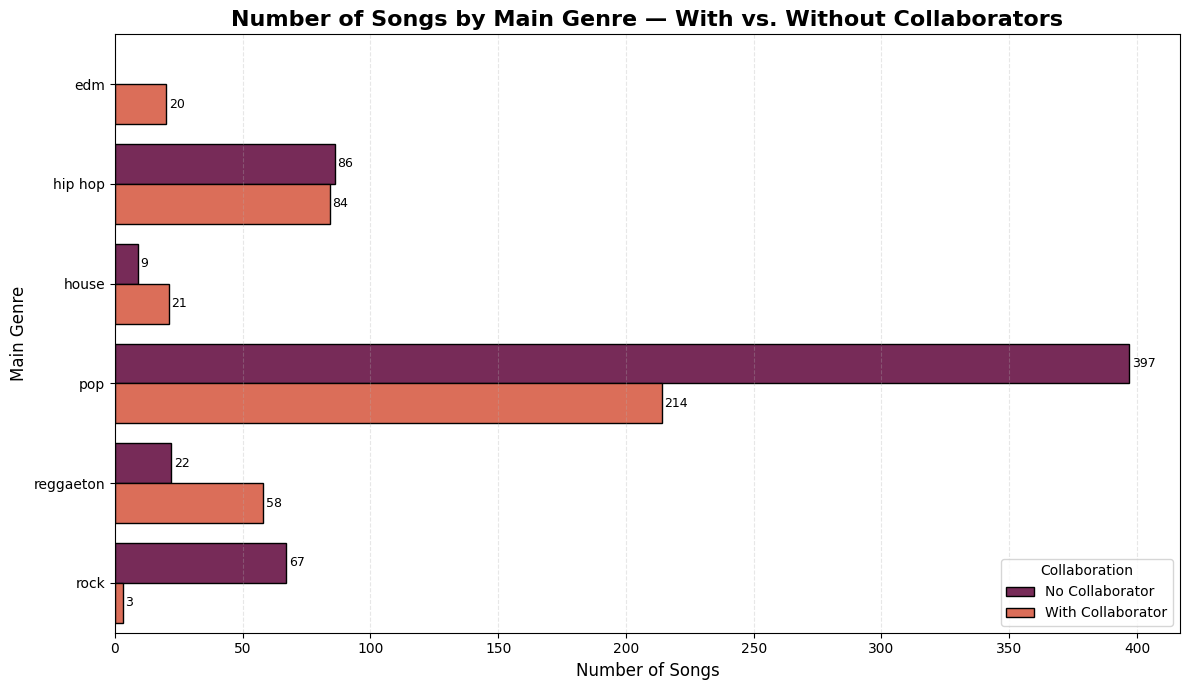

In [12]:
# Plot track counts instead of average popularity
plt.figure(figsize=(12, 7))
ax = sns.barplot(
    data=main_genre_collab_stats,
    x='count',
    y='main_genres',
    hue='has_collaborator',
    #order=genre_order,
    palette='rocket',
    edgecolor='black'
)

# Annotate count on each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=9, padding=2)

plt.title("Number of Songs by Main Genre — With vs. Without Collaborators", fontsize=16, weight='bold')
plt.xlabel("Number of Songs", fontsize=12)
plt.ylabel("Main Genre", fontsize=12)

# Fix legend labels based on actual boolean values
handles, labels = ax.get_legend_handles_labels()
custom_labels = ['No Collaborator', 'With Collaborator']
ax.legend(handles=handles, labels=custom_labels, title="Collaboration", loc='lower right')

plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


# Tempo, key, and popularity

/var/folders/hb/_102c3q564q52vqhw3vdnx1h0000gp/T/ipykernel_8299/196478250.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


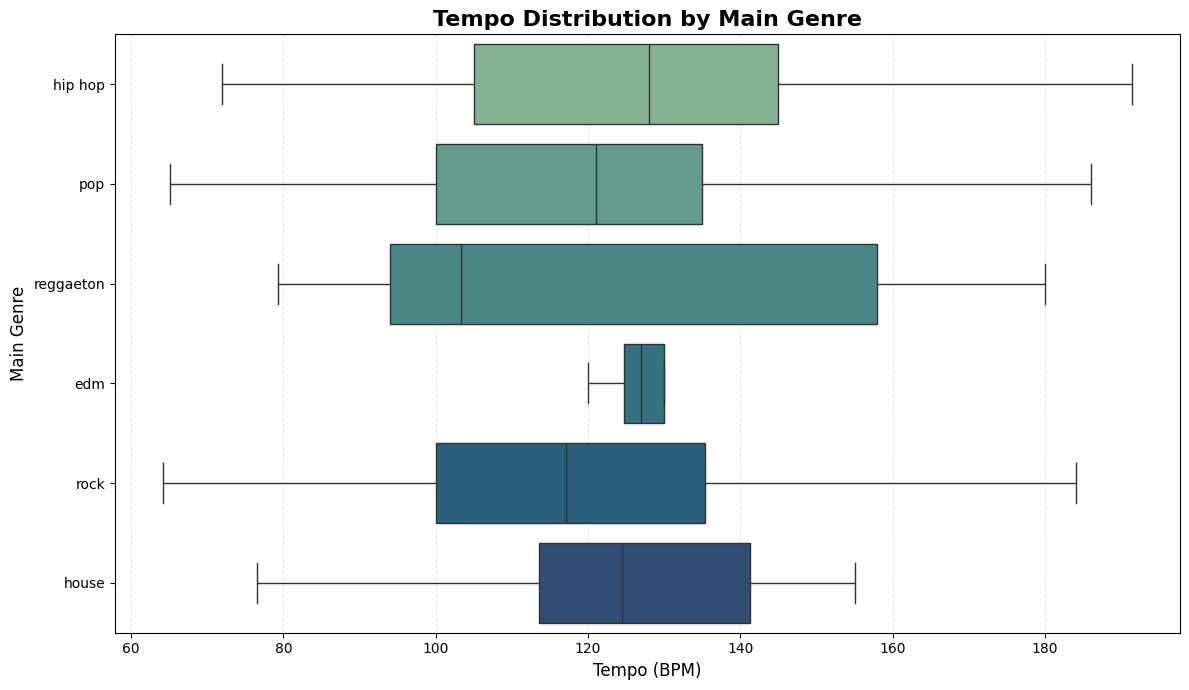

In [13]:
# Step 1: Explode main_genres to one genre per row
exploded_tempo = data.explode('main_genres')
exploded_tempo = exploded_tempo.dropna(subset=['main_genres', 'tempo'])

# Step 2: Plot tempo distribution
plt.figure(figsize=(12, 7))
sns.boxplot(
    data=exploded_tempo,
    x='tempo',
    y='main_genres',
    palette='crest',
    showfliers=False  # Hide outliers for cleaner plot
)

plt.title("Tempo Distribution by Main Genre", fontsize=16, weight='bold')
plt.xlabel("Tempo (BPM)", fontsize=12)
plt.ylabel("Main Genre", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

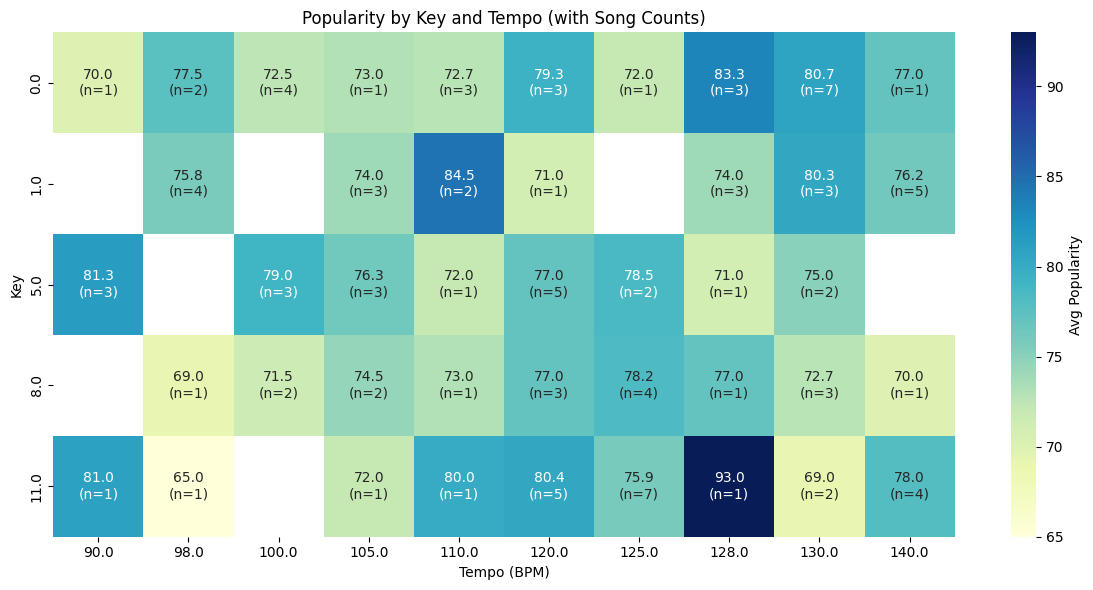

In [14]:
# Step 1: Filter for most common tempos and keys
common_tempos = data['tempo'].round().value_counts().nlargest(10).index.tolist()
common_keys = data['key'].value_counts().nlargest(5).index.tolist()

filtered = data[
    data['tempo'].round().isin(common_tempos) & 
    data['key'].isin(common_keys)
].copy()

# Round tempo
filtered['tempo_rounded'] = filtered['tempo'].round()

# Step 2: Group by key and tempo
grouped = (
    filtered.groupby(['key', 'tempo_rounded'])
    .agg(avg_popularity=('popularity', 'mean'), count=('popularity', 'count'))
    .reset_index()
)

# Step 3: Pivot both metrics
pivot_avg = grouped.pivot(index='key', columns='tempo_rounded', values='avg_popularity')
pivot_count = grouped.pivot(index='key', columns='tempo_rounded', values='count')

# Step 4: Create annotations like "74.2\n(n=53)"
annotations = pivot_avg.copy().astype(str)
for i in pivot_avg.index:
    for j in pivot_avg.columns:
        pop = pivot_avg.loc[i, j]
        cnt = pivot_count.loc[i, j]
        if pd.notna(pop) and pd.notna(cnt):
            annotations.loc[i, j] = f"{pop:.1f}\n(n={int(cnt)})"
        else:
            annotations.loc[i, j] = ""

# Step 5: Plot
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_avg, annot=annotations, fmt='', cmap='YlGnBu', cbar_kws={'label': 'Avg Popularity'})
plt.title("Popularity by Key and Tempo (with Song Counts)")
plt.xlabel("Tempo (BPM)")
plt.ylabel("Key")
plt.tight_layout()
plt.show()

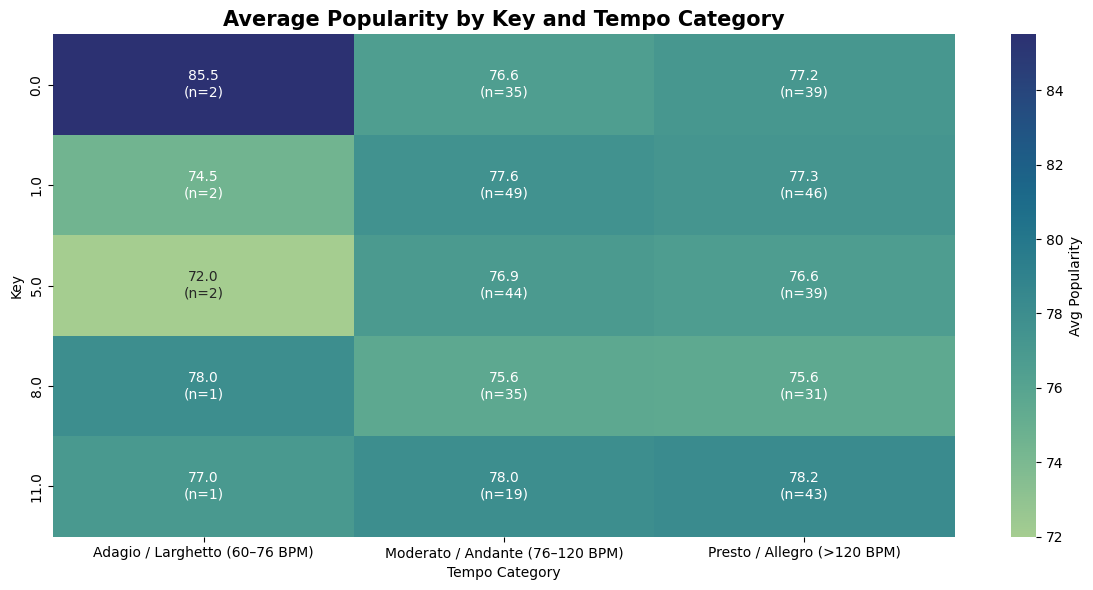

In [ ]:
# Step 1: Define tempo group function
def categorize_tempo(bpm):
    if bpm > 120:
        return 'Presto / Allegro (>120 BPM)'
    elif 76 <= bpm <= 120:
        return 'Moderato / Andante (76–120 BPM)'
    elif 60 <= bpm < 76:
        return 'Adagio / Larghetto (60–76 BPM)'
    else:
        return 'Other (<60 BPM)'

# Step 2: Filter data to common keys
common_keys = data['key'].value_counts().nlargest(5).index.tolist()
filtered = data[data['key'].isin(common_keys)].copy()

# Step 3: Categorize tempo
filtered['tempo_group'] = filtered['tempo'].apply(categorize_tempo)

# Step 4: Group by key and tempo group
grouped = (
    filtered.groupby(['key', 'tempo_group'])
    .agg(avg_popularity=('popularity', 'mean'), count=('popularity', 'count'))
    .reset_index()
)

# Step 5: Pivot tables
pivot_avg = grouped.pivot(index='key', columns='tempo_group', values='avg_popularity')
pivot_count = grouped.pivot(index='key', columns='tempo_group', values='count')

# Step 6: Build annotations
annotations = pivot_avg.copy().astype(str)
for i in pivot_avg.index:
    for j in pivot_avg.columns:
        pop = pivot_avg.loc[i, j]
        cnt = pivot_count.loc[i, j]
        if pd.notna(pop) and pd.notna(cnt):
            annotations.loc[i, j] = f"{pop:.1f}\n(n={int(cnt)})"
        else:
            annotations.loc[i, j] = ""

# Step 7: Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_avg, annot=annotations, fmt='', cmap='crest', cbar_kws={'label': 'Avg Popularity'})
plt.title("Average Popularity by Key and Tempo Category", fontsize=15, weight='bold')
plt.xlabel("Tempo Category")
plt.ylabel("Key")
plt.tight_layout()
plt.show()

#popularity here doesn't really matter as we are already looking at the top tracks

# 

# Date and popularity

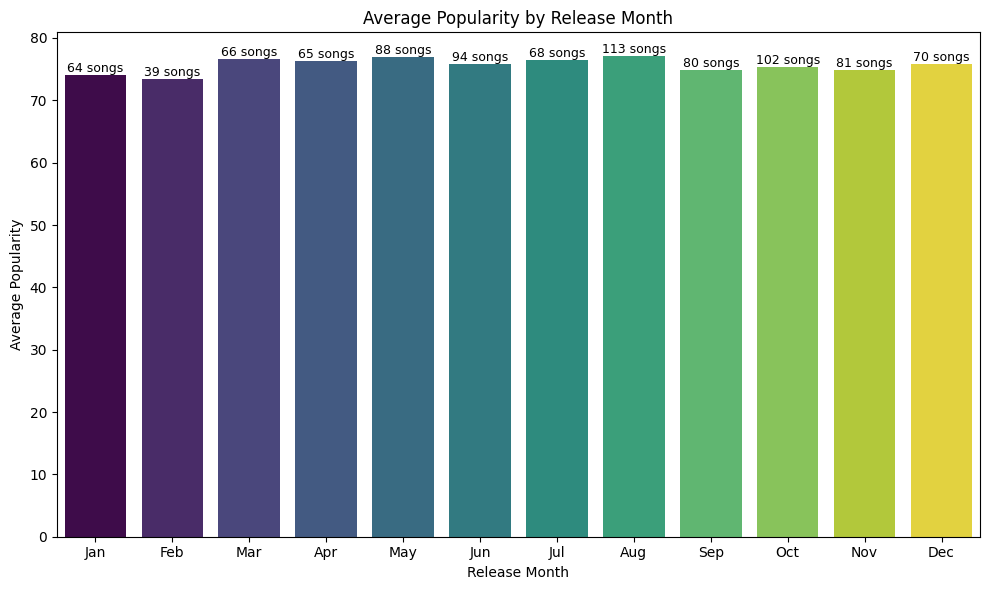

In [16]:
# Ensure release_month is extracted
data['release_month'] = (
    pd.to_datetime(data['release_date'], errors='coerce', format='%Y-%m-%d')
    .dt.month
)

# Group by month: compute average and count
monthly_avg = (
    data.groupby('release_month')['popularity']
    .agg(['mean', 'count'])
    .reset_index()
    .rename(columns={'mean': 'avg_popularity', 'count': 'song_count'})
)

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='release_month',
    y='avg_popularity',
    hue='release_month',
    data=monthly_avg,
    palette='viridis',
    legend=False
)

# Add song count labels on top of each bar
for container, count in zip(ax.containers, monthly_avg['song_count']):
    for bar in container:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{count} songs",
            ha='center',
            va='bottom',
            fontsize=9
        )
        break  # prevent repeated labeling — one per bar group

plt.title("Average Popularity by Release Month")
plt.xlabel("Release Month")
plt.ylabel("Average Popularity")
plt.xticks(
    ticks=range(0, 12),
    labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
)
plt.tight_layout()
plt.show()


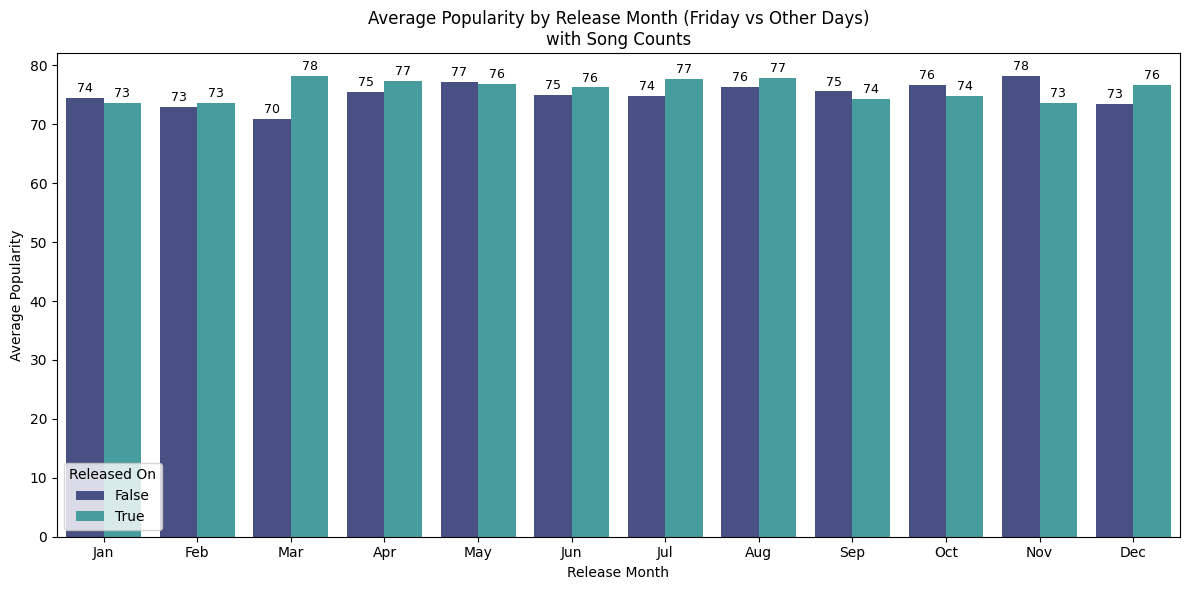

In [17]:
# Ensure datetime parsing
data['release_day'] = pd.to_datetime(data['release_date'], errors='coerce')

# Extract month and Friday flag
data['release_month'] = data['release_day'].dt.month
data['friday'] = data['release_day'].dt.dayofweek == 4
monthly_popularity = (
    data.groupby(['release_month', 'friday'])['popularity']
    .mean()
    .reset_index()
)
# Group by release_month and friday, get count and mean
monthly_stats = (
    data.groupby(['release_month', 'friday'])
    .agg(song_count=('popularity', 'count'),  # count songs
         avg_popularity=('popularity', 'mean'))  # average popularity
    .reset_index()
)

# Label for clarity
monthly_popularity['friday'] = monthly_popularity['friday'].map({True: 'Friday', False: 'Other Days'})

monthly_popularity = (
    data.groupby(['release_month', 'friday'])['popularity']
    .mean()
    .reset_index()
)

# Label for clarity
monthly_popularity['friday'] = monthly_popularity['friday'].map({True: 'Friday', False: 'Other Days'})

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=monthly_stats,
    x='release_month',
    y='avg_popularity',
    hue='friday',
    palette='mako'
)

# Annotate with song counts on top of each bar
for container in ax.containers:
    ax.bar_label(container, labels=[
        f"{int(c)}" for c in container.datavalues
    ], label_type='edge', fontsize=9, padding=2)

plt.title("Average Popularity by Release Month (Friday vs Other Days)\nwith Song Counts")
plt.xlabel("Release Month")
plt.ylabel("Average Popularity")
plt.xticks(ticks=range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Released On')
plt.tight_layout()
plt.show()



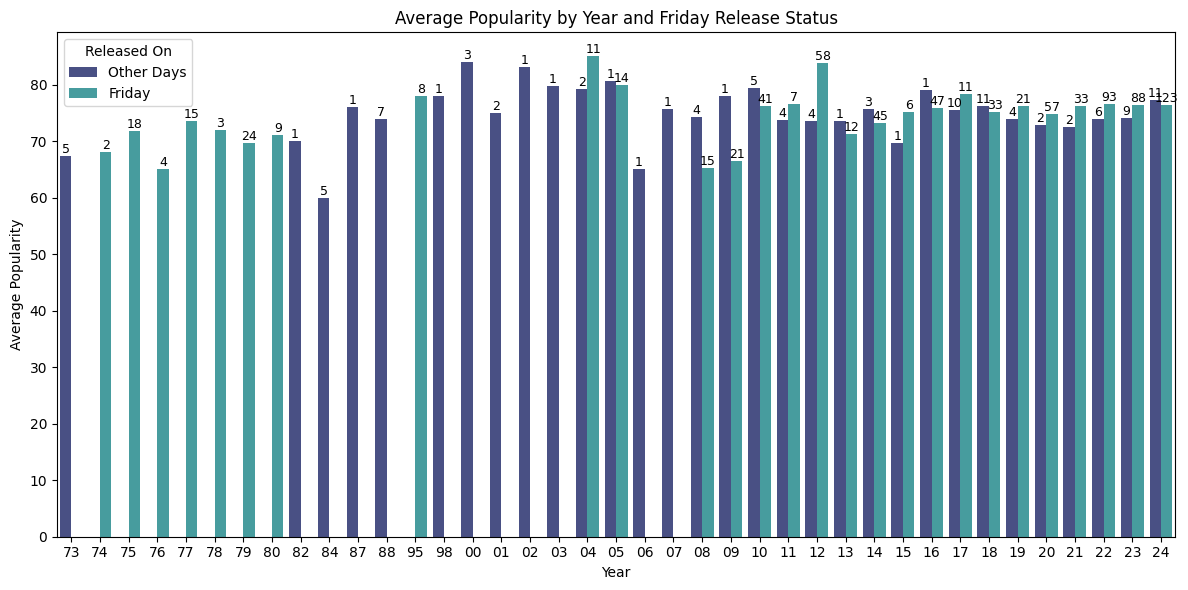

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure datetime parsing
data['release_day'] = pd.to_datetime(data['release_date'], errors='coerce')
data['release_year'] = data['release_day'].dt.year
data['friday'] = data['release_day'].dt.dayofweek == 4

# Group by year and Friday flag
yearly_stats = (
    data.groupby(['release_year', 'friday'])
    .agg(song_count=('popularity', 'count'),
         avg_popularity=('popularity', 'mean'))
    .reset_index()
)

# Map for clarity
yearly_stats['friday'] = yearly_stats['friday'].map({True: 'Friday', False: 'Other Days'})

# Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=yearly_stats,
    x='release_year',
    y='avg_popularity',
    hue='friday',
    palette='mako'
)

# Add song count above each bar
i = 0
for container in ax.containers:
    for bar in container:
        count = yearly_stats.iloc[i]['song_count']
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{count}",
            ha='center',
            va='bottom',
            fontsize=9
        )
        i += 1

# Format x-axis labels to last 2 digits of year
unique_years = sorted(yearly_stats['release_year'].unique())
ax.set_xticks(range(len(unique_years)))
ax.set_xticklabels([str(int(y))[-2:] for y in unique_years])

plt.title("Average Popularity by Year and Friday Release Status")
plt.xlabel("Year")
plt.ylabel("Average Popularity")
plt.legend(title="Released On")
plt.tight_layout()
plt.show()


# Danceability

Correlation between popularity and danceability: -0.04606349289911359


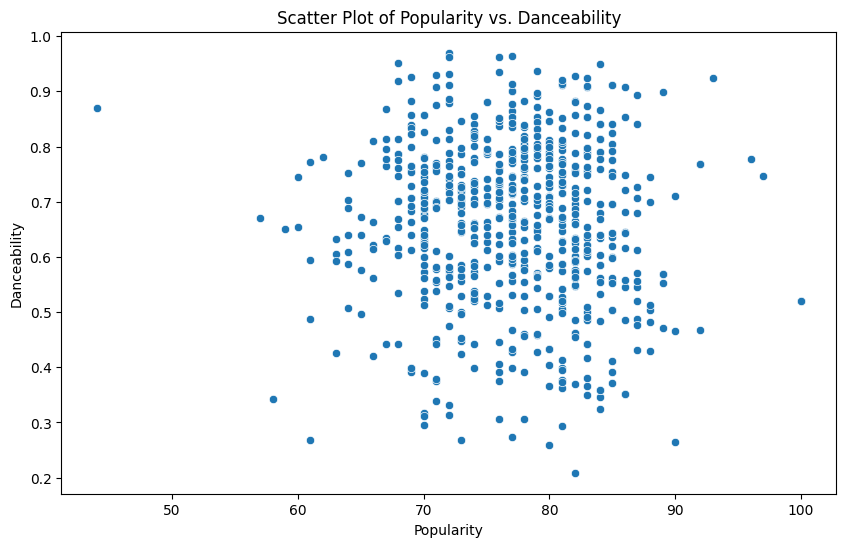

In [19]:
# Correlation between popularity and danceability
correlation_popularity_danceability = data['popularity'].corr(data['danceability'])
print("Correlation between popularity and danceability:", correlation_popularity_danceability)

# Scatter plot for popularity vs. danceability
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['popularity'], y=data['danceability'])
plt.title("Scatter Plot of Popularity vs. Danceability")
plt.xlabel("Popularity")
plt.ylabel("Danceability")
plt.show()
